# An Analysis of the MoMA's Collection by Race and Gender
This notebook will explore the MoMA's publicly available artwork dataset, primarily on a pivot of race and gender (but also brieftly looking at nationality). We will try to understand the MoMA's collection from the standpoint of demographic and geographic diversity and identify any trends in the MoMA's collecting tendencies with regards to race and gender.

## Outline of methodology of the analysis
1. Starting with the artworks dataset (`artworks.csv`), pull out the artist data to create an `artist_df`.
2. Using the `artist_df`, visualize the gender and nationality ratio
2. Using the `lastnames.json` dataset, which is a mapping of last names to probability of race, associate each artist with a race.
3. Compare the distribution of race of MoMA artists with the distribution of race in the US
4. Join artist race data back with the artworks dataset so that we can understand the same distributions of race and gender at the artwork granularity.
5. Examine the artworks collected by the date it was acquired ('date_acquired') and visualize the MoMAs collecting tendencies over time by race and gender.


## Dependencies

This file depends the following files located in the root of this project:
- `data/artworks.csv` - this file was downloaded from https://github.com/MuseumofModernArt/collection/blob/master/Artworks.csv on 2/15/2018
- `data/lastnames.json` - this file was downloaded from https://api.census.gov/data/2010/surname.html

This file also depends on the following utility file that contains many helper functions:
- `./util.py`

Import libraries and specify path to data

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import util
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

data_folder = os.path.join("..", "data")

## Load artworks dataset and transform into an artists dataset
Lets start by pulling in the `data/artworks.csv` dataset and pulling out the artist information. To do so, we need to make an `artist_df` by only selecting columns "artist_name", "constituent_id", "nationality" and "gender", and then droping the duplicates.

Once we have our new dataframe, we need to split the rows that look like this:
```
| -------------- | ------------------------ | ------------------ | ------------- |
| constituent_id | artist_name              | nationality        | gender        |
| -------------- | ------------------------ | ------------------ | ------------- |
| 1234, 2345     | Cai Guo Qiang, Duchamp   | (Chinese) (French) | (Male) (Male) |
```
into this:
```
| -------------- | ------------------------ | ------------------ | ------------- |
| constituent_id | artist_name              | nationality        | gender        |
| -------------- | ------------------------ | ------------------ | ------------- |
| 1234           | cai guo qiang            | chinese            | male          |
| 2345           | duchamp                  | french             | male          |
```
We can achieve that by running the `split_rows()` util method on the `artist_df`

There are many artist names (`artist_name`) that belong to groups or companies, such as 'The Velvet Underground' or 'hats incredible, inc., braintree, ma' -- remove rows where artists are entities so that we can get accurate data for race and gender.

In [2]:
raw_artwork_df = pd.read_csv(os.path.join(data_folder, "artworks.csv") , names=[
        'title', 
        'artist_name', 
        'constituent_id', 
        'artist_bio', 
        'nationality', 
        'begin_date', 
        'end_date', 
        'gender', 
        'date', 
        'medium', 
        'dimensions', 
        'credit_line', 
        'accession_number', 
        'classification', 
        'department', 
        'date_acquired', 
        'cataloged', 
        'object_id', 
        'url', 
        'thumbnail_url', 
        'circumference_cm', 
        'depth_cm', 
        'diameter_cm', 
        'height_cm', 
        'length_cm', 
        'weight_kg', 
        'width_cm', 
        'seat_height_cm', 
        'durcation_seconds']).drop(0, axis=0)

# get rows of artists from artwork_df
artist_df = raw_artwork_df[['constituent_id', 'artist_name', 'nationality', 'gender']].drop_duplicates()

# run split_rows on artist_df to split rows where multiple artists are in one row
artist_df = util.split_rows(artist_df)

# remove parentheses from nationality and gender 
artist_df['nationality'] = artist_df['nationality'].apply(lambda x: x.replace('(', '').replace(')', ''))
artist_df['gender'] = artist_df['gender'].apply(lambda x: x.replace('(', '').replace(')', ''))

# replace empty strings with NaNs
artist_df = artist_df.replace('', np.nan, regex=True)

# remove if artist is_entity
artist_df = artist_df[artist_df['artist_name'].apply(util.get_is_not_entity_from_full_name)]

# show data
display(artist_df.head())
print(artist_df.shape)

/home/jiata/anaconda3/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17,20,21,22,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,constituent_id,artist_name,nationality,gender
0,6210,otto wagner,austrian,male
1,7470,christian de portzamparc,french,male
2,7605,emil hoppe,austrian,male
3,7056,bernard tschumi,NaN,male
4,2964,louis i. kahn,american,male


(13749, 4)


## Comparing the MoMA's collection by Gender and Nationality
We start by simply looking at the distribution of gender and nationality amongst artists that have been collected by the MoMA.

In [3]:
# Toggle this value to show or hide NaN values
PLOT_NAN_VALUES = True

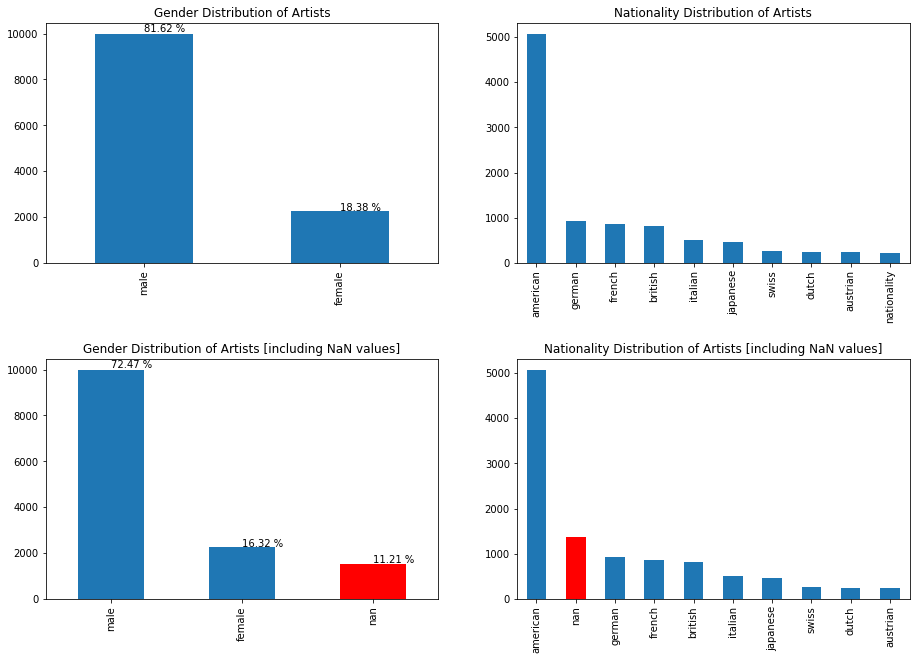

In [4]:
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

util.plot_distribution(
    dist_df=artist_df['gender'].value_counts(dropna=True), 
    title="Gender Distribution of Artists",
    ax=ax1)

util.plot_distribution(
    dist_df=artist_df['nationality'].value_counts(dropna=True).iloc[0:10,],
    title="Nationality Distribution of Artists",
    ax=ax2, show_pct=False)

if PLOT_NAN_VALUES:
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    util.plot_distribution(
        dist_df=artist_df['gender'].value_counts(dropna=False), 
        title="Gender Distribution of Artists [including NaN values]",
        ax=ax3)

    util.plot_distribution(
        dist_df=artist_df['nationality'].value_counts(dropna=False).iloc[0:10,],
        title="Nationality Distribution of Artists [including NaN values]",
        ax=ax4, show_pct=False)

### Shortcomings of this methodology

This datasets primary limitation is that it uses a binary definition of gender and so we are limited to either male or female. This does not work for artists who do not conform to the male/female gender binary, and for artist groups that have multiple members of which there could be multiple genders.

Additionally, there are a lot of NaN values in the dataset for nationality and gender. About 12% of the dataset has values of NaN for gender.

---


## Mapping a race to each artist

With the dataset we have, the best indicator of race is via the lastname/surname of the artist. We will be using artist names (`artist_name`) to make guesses as to which race best identifies them.

In order to assign a race to each artist, we need to use the dataset `lastname_race_df` which comes from https://api.census.gov/data/2010/surname.html. 

We will first need to figure out what part of the `artist_name` string is the lastname. To do this, we will start from the last word of the `artist_name`, and iteratively check whether or not the word has a match in the `lastname_race_df`.

For example, if we get the name "Millie Bobby Brown",
1. we will start by checking whether or not 'Brown' maps to some name in the `lastname_race_df`
2. if so, we will assign the artist with a race, otherwise, check to see whether or not 'Bobby' maps to some name in the `lastname_race_df`
3. if so, we will assign the artist with a race, otherwise, check to see whether or not 'Millie' maps to some name in the `lastname_race_df`
4. if so, we will assign the artist with a race, otherwise, we assign the artist with a race of NaN

__So how do we assign the artist with a race?__
        
This dataset provides the probability (in percentage) of a race given a lastname. In order to assign a race to each artist, we will draw a random race such that the probabilities of the name belonging to the race is defined by the probabilities provided in the `lastname_race_df`. This will mean that on each run, there is a chance that the race assigned to each artist will be different.

For example, if we were to assign the lastname "Brown" to a race,
1. we will start by looking for the probability distribution of races given the lastname "Brown"
2. with the probability distribution, we choose a random variable race, distributed by the probability distribution of races for the last name "Brown"

With this methodology, we can append a new 'race' column to the artist dataframe.

Start by loading/viewing the `lastname_race_df`:

In [5]:
lastname_race_df = util.get_race_dist_of_lastname()
lastname_race_df.head()

,lastname,white,asian,mix,aian,black,hispanic
1,smith,0.7090,0.0050,0.0219,0.0089,0.2311,0.0240
2,johnson,0.5897,0.0054,0.0256,0.0094,0.3463,0.0236
3,williams,0.4575,0.0046,0.0281,0.0082,0.4768,0.0249
4,brown,0.5795,0.0051,0.0255,0.0087,0.3560,0.0252
5,jones,0.5519,0.0044,0.0261,0.0100,0.3848,0.0229


Using the method described above, join the `artist_df` with `lastname_race_df` to assign each artist a race based their name. 

To do this, we will apply the `get_race_from_full_name()` method to each name, which will iterate through words in the name, checking that the word exists in the `lastname_race_df`, and assigning it a random race given the probabilities.

In [6]:
""" COMPUTATIONALLY EXPENSIVE """
# create mapping with `lastname_race_df` to find assign a race to each artists
artist_df['race'] = artist_df['artist_name'].apply(util.get_race_from_full_name, args=(lastname_race_df,))

Because the `lastname_race_df` dataset comes from the uscensus, we should limit this join to only American artists as it is likely to produce inaccurate results for non-American artists. It would also be interesting to see the result of of most likely race of non-american's as a point of comparison.

In [7]:
# filter on american artists only
american_artist_df = artist_df[artist_df['nationality'] == 'american']
non_american_artist_df = artist_df[artist_df['nationality'] != 'american']

We'll also want to look at the overall race distribution in america so that we can make a comparison to the race distribution of MoMA artists.

In [8]:
"""
HARD-CODED Data
Datasource: https://www.kff.org/other/state-indicator/distribution-by-raceethnicity
Date of data: 2016
"""
race_dist_df = pd.DataFrame({
    'race': ['white', 'black', 'asian', 'aian', 'mix', 'hispanic'],
    'america': [0.61, 0.12, 0.06, 0.01, 0.02, 0.18]
}).set_index('race')

In [9]:
# Toggle this value to show or hide NaN values
PLOT_NAN_VALUES = False

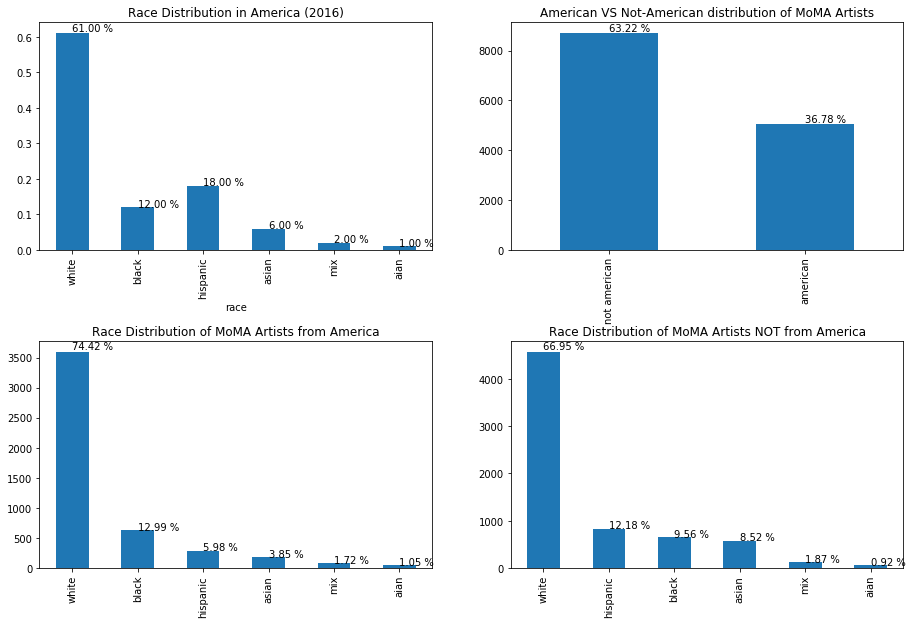

In [10]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)

# Race distribution of people in America
util.plot_distribution(
    dist_df=race_dist_df['america'][['white', 'black', 'hispanic', 'asian', 'mix', 'aian']],
    title="Race Distribution in America (2016)",
    ax=ax1)

# total Artists by is_american vs not_american
is_american_artist_df = artist_df['nationality'].map(lambda x: 'american' if x == 'american' else 'not american')
util.plot_distribution(
    dist_df=is_american_artist_df.value_counts(),
    title="American VS Not-American distribution of MoMA Artists",
    ax=ax2)

# Race distribution of Artists from America
util.plot_distribution(
    dist_df=american_artist_df['race'].value_counts(dropna=True), 
    title="Race Distribution of MoMA Artists from America",
    ax=ax3)

# Race distribution of Artists NOT from America
util.plot_distribution(
    dist_df=non_american_artist_df['race'].value_counts(dropna=True), 
    title="Race Distribution of MoMA Artists NOT from America",
    ax=ax4)

if PLOT_NAN_VALUES:
    ax5 = fig.add_subplot(325)
    ax6 = fig.add_subplot(326)
    
    # Race distribution of Artists from America
    util.plot_distribution(
        dist_df=american_artist_df['race'].value_counts(dropna=False), 
        title="Race Distribution of MoMA Artists from America [including NaNs]",
        ax=ax5)

    # Race distribution of Artists NOT from America
    util.plot_distribution(
        dist_df=non_american_artist_df['race'].value_counts(dropna=False), 
        title="Race Distribution of MoMA Artists NOT from America [including NaNs]",
        ax=ax6)


### Shortcomings of this methodology
The dataset with the race distributions of lastnames to race comes from 2010, while the range of artists in the MoMA's collection spans across the 20th century uptil today.

Because the `lastname_race_df` dataset comes from the uscensus, we should also limit this join to only American artists as it may to produce inaccurate results for non-American artists.

One of the main shortcomings of using this method to compare race and gender is that you could have two artists where one has multiple pieces collected by the MoMA whereas the other only has one piece collected by the MoMA. This leads into the work for the next section.

---


## Exploring the Artworks dataset

This next section will return to the artworks dataset, pulling in race and gender data from the `artist_df` dataframe. This will give us an understanding of the race and gender distribution at the granularity of collected artworks.

In [11]:
artwork_df = raw_artwork_df[[
        'constituent_id',
        'nationality',
        'date_acquired']]

artwork_df[['male', 'female', 'white', 'black', 'asian', 'aian', 'mix', 'hispanic']] = \
    artwork_df['constituent_id'].apply(util.join_race_and_gender, args=(artist_df,)).apply(pd.Series)

display(artwork_df.head())
print(artwork_df.shape)

,constituent_id,nationality,date_acquired,male,female,white,black,asian,aian,mix,hispanic
1,6210,(Austrian),1996-04-09,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,7470,(French),1995-01-17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7605,(Austrian),1997-01-15,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,7056,(),1995-01-17,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,7605,(Austrian),1997-01-15,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


(132997, 11)


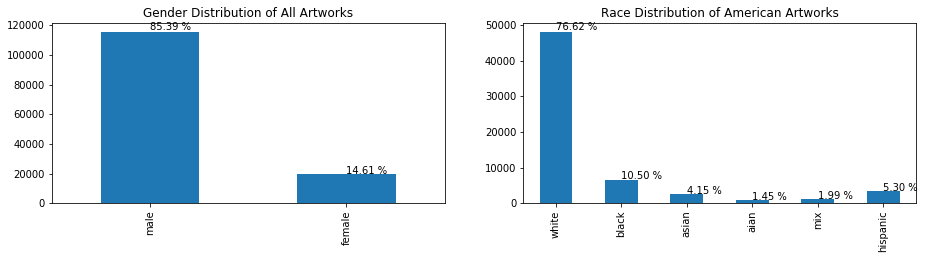

In [12]:
fig = plt.figure(figsize=(12, 6))
plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

util.plot_distribution(
    dist_df=artwork_df[['male', 'female']].sum(), 
    title="Gender Distribution of All Artworks",
    ax=ax1)

american_artwork_df = artwork_df.dropna(subset=['nationality']) 
american_artwork_df = american_artwork_df[american_artwork_df['nationality'].str.contains('American')]

util.plot_distribution(
    dist_df=american_artwork_df[['white', 'black', 'asian', 'aian', 'mix', 'hispanic']].sum(), 
    title="Race Distribution of American Artworks",
    ax=ax2)

Starting with gender, lets plot the total artworks collectec by gender as well as the percentage collected by gender.

/home/jiata/code/moma/code/util.py:242: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  artwork_with_date_df = artwork_with_date_df[artwork_df['date_acquired'].notnull()]
/home/jiata/code/moma/code/util.py:242: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  artwork_with_date_df = artwork_with_date_df[artwork_df['date_acquired'].notnull()]


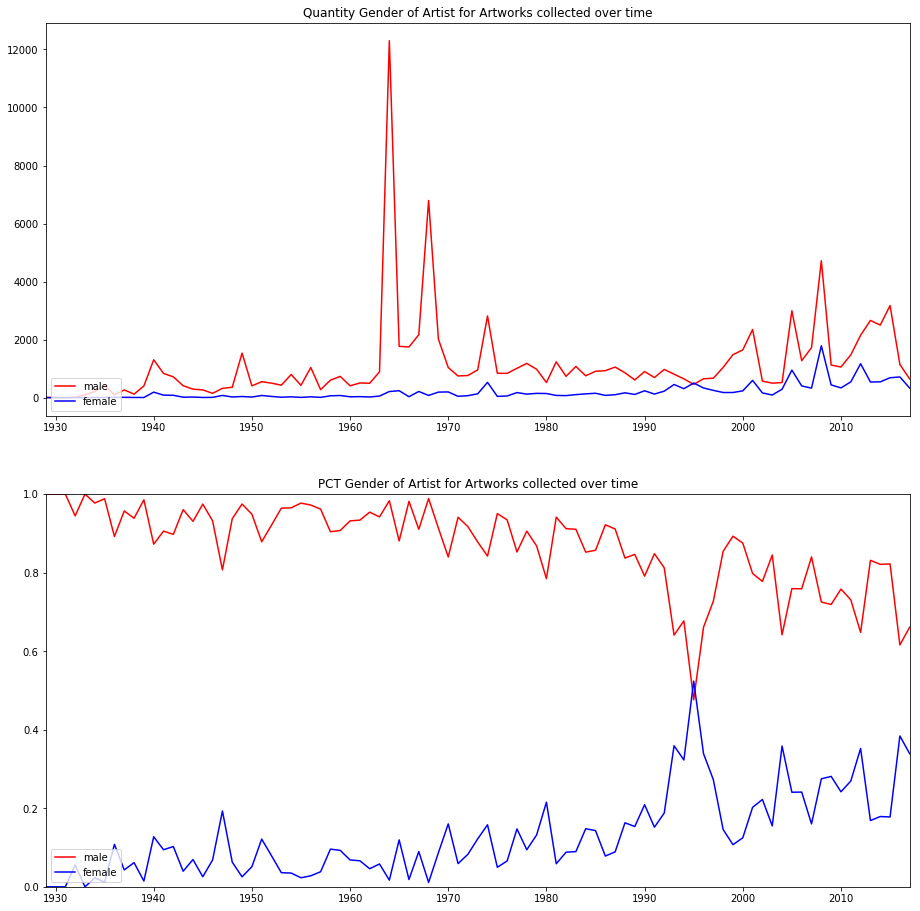

In [13]:
# plot hist
fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.2)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# plot pct area graph for gender distribution
util.plot_acquisition_by_year(
    artwork_df=artwork_df, 
    ax=ax1,
    features=['male', 'female'], 
    color_list=['red', 'blue'], 
    title="Quantity Gender of Artist for Artworks collected over time", 
    pct=False)


# plot pct area graph for gender distribution
util.plot_acquisition_by_year(
    artwork_df=artwork_df, 
    ax=ax2,
    features=['male', 'female'], 
    color_list=['red', 'blue'], 
    title="PCT Gender of Artist for Artworks collected over time", 
    pct=True)


Lets also plot the total artworks collectect by race, as well the percentage collected by each race (excluding whites) as compared to whites.

/home/jiata/code/moma/code/util.py:242: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  artwork_with_date_df = artwork_with_date_df[artwork_df['date_acquired'].notnull()]


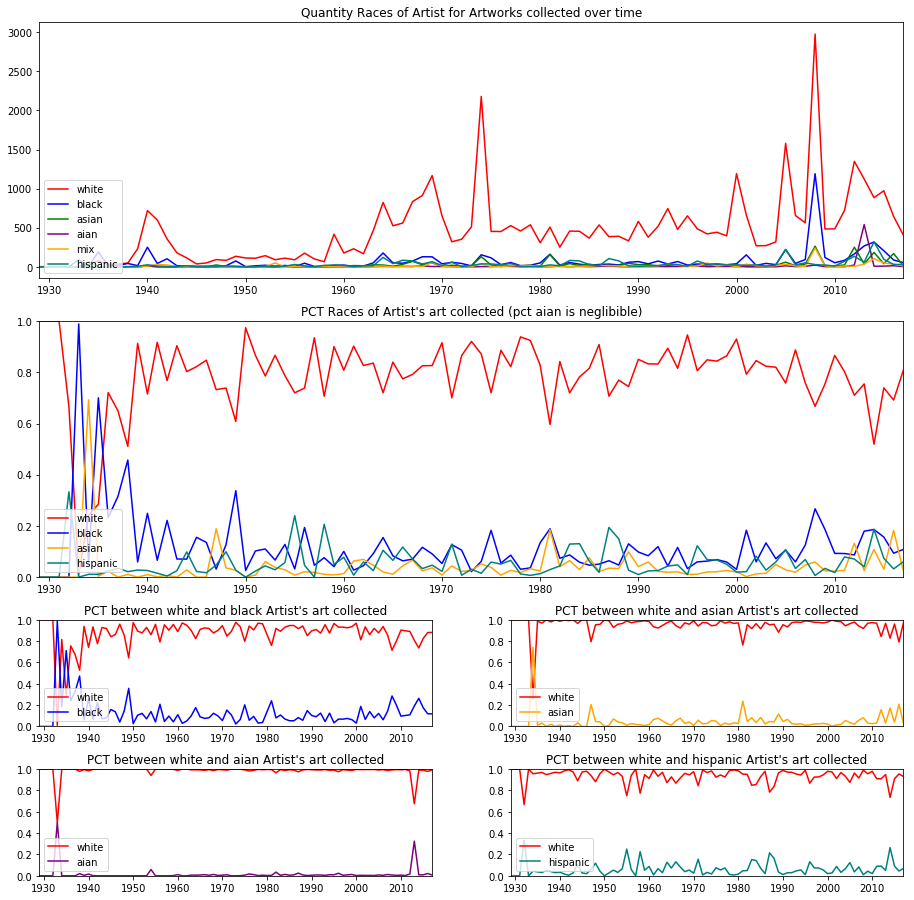

In [14]:
fig = plt.figure(figsize=(12, 16))
plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.4)
ax1 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((8, 2), (2, 0), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((8, 2), (4, 0))
ax4 = plt.subplot2grid((8, 2), (4, 1))
ax5 = plt.subplot2grid((8, 2), (5, 0))
ax6 = plt.subplot2grid((8, 2), (5, 1))

# plot pct area graph for race distribution
util.plot_acquisition_by_year(
    artwork_df=american_artwork_df, 
    ax=ax1,
    features=['white', 'black', 'asian', 'aian', 'mix', 'hispanic'], 
    color_list=['red', 'blue', 'green', 'purple', 'orange', 'teal'], 
    title="Quantity Races of Artist for Artworks collected over time", 
    pct=False)

# plot pct area graph for race distribution
util.plot_acquisition_by_year(
    artwork_df=american_artwork_df, 
    ax=ax2,
    features=['white', 'black', 'asian', 'hispanic'], 
    color_list=['red', 'blue', 'orange', 'teal'], 
    title="PCT Races of Artist's art collected (pct aian is neglibible)", 
    pct=True)

_races = ['black', 'asian', 'aian', 'hispanic']
_colors = ['blue', 'orange', 'purple', 'teal']
_ax = [ax3, ax4, ax5, ax6]

for race, color, ax in zip(_races, _colors, _ax):
    # plot pct area graph for race distribution
    util.plot_acquisition_by_year(
        artwork_df=american_artwork_df, 
        ax=ax,
        features=['white', race], 
        color_list=['red', color], 
        title="PCT between white and %s Artist's art collected" % race, 
        pct=True)